In [15]:
import os
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from statsmodels import api as sm
from sklearn.metrics import mean_squared_error as mse
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter, YearLocator, MonthLocator
from matplotlib.ticker import FixedLocator
import itertools
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

# 1. Get data

### Web scraping

In [2]:
def parse_url(from_year, from_month, to_year, to_month):
    """Parse exchange rate data.

    Args:
        from_year (int): from `year` filter
        from_month (int): from `month` filter
        to_year (int): to `year` filter
        to_month (int): to `month` filter

    Returns:
        table (bs4.element.Tag): html table

    """
    url = "https://www.mongolbank.mn/dblistofficialaveragemonthlydynamic.aspx?vYear1={}&vYear2={}&vMonth1={}&vMonth2={}".format(from_year, to_year, from_month, to_month)
    response = requests.get(url)

    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'lxml')
        table = soup.find_all('table', {'class': 'bom-dbstatTable'})[0]
        return table

    else:
        print('No data found.')


def parse_html_table(soup_table):
    """Extract exchange rate data.

    Args:
        soup_table (bs4.element.Tag): html table

    Returns:
        data (dict): exchange rate data stored in dictionary

    """
    column_names = []

    # Get currency headers
    for row in soup_table.find_all('tr')[1].find_all('th'):
        column_names.append(row.get_text())
        
    column_names[0]='Date'
        
    # Create an empty dictionary for storing data
    data = {key:[] for key in column_names}
    
    # Get exchange rate data
    for item in soup_table.find_all('tr')[2:]:
        table_tags = item.find_all(['th', 'td'])
        {data[key].append(value.get_text()) for key, value in zip(column_names, table_tags)}
    
    return data
    

def dict_to_df(dict_data):
    """Convert dictionary into pandas dataframe & cleaning.

    Args:
        dict_data (dict): exchange rate data

    Returns:
        df (DataFrame): exchange rate date stored in dataframe

    """
    # Convert into dataframe
    df = pd.DataFrame.from_dict(dict_data)
    
    # Convert data types & set index & drop null rows & sort
    df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m')
    df.set_index('Date', inplace=True)
    df = df.replace(',', '', regex=True)
    df = df.replace('', np.nan, regex=True)
    df.dropna(inplace=True)
    df = df.astype(float)
    df.sort_index(inplace=True)
    
    return df

In [3]:
# Get exchange rate dataframe
soup_table = parse_url(1993, 1, 2019, 12)
data_dict = parse_html_table(soup_table)
df = dict_to_df(data_dict)

print(df.tail())

                USD      EUR    JPY      GBP    RUB     CNY   KRW      SGD  \
Date                                                                         
2019-07-01  2661.55  2984.83  24.59  3317.09  42.06  386.98  2.26  1954.68   
2019-08-01  2670.54  2970.86  25.13  3243.34  40.66  378.16  2.21  1928.21   
2019-09-01  2669.68  2940.57  24.84  3297.63  41.15  375.28  2.24  1935.46   
2019-10-01  2678.01  2958.16  24.76  3379.99  41.62  377.38  2.26  1953.07   
2019-11-01  2705.26  2991.82  24.85  3487.55  42.38  385.47  2.32  1987.51   

                CAD      AUD  
Date                          
2019-07-01  2030.65  1858.27  
2019-08-01  2012.37  1808.05  
2019-09-01  2016.41  1819.09  
2019-10-01  2029.74  1818.31  
2019-11-01  2045.00  1849.40  


### Alternatively, import from csv file

In [4]:
# Get exchange rate dataframe
df = pd.read_csv('./data/exchange_rate.csv', index_col='Date')
df.index = pd.to_datetime(df.index)

print(df.tail())

                USD      EUR    JPY      GBP    RUB     CNY   KRW      SGD  \
Date                                                                         
2019-07-01  2661.55  2984.83  24.59  3317.09  42.06  386.98  2.26  1954.68   
2019-08-01  2670.54  2970.86  25.13  3243.34  40.66  378.16  2.21  1928.21   
2019-09-01  2669.68  2940.57  24.84  3297.63  41.15  375.28  2.24  1935.46   
2019-10-01  2678.01  2958.16  24.76  3379.99  41.62  377.38  2.26  1953.07   
2019-11-01  2705.26  2991.82  24.85  3487.55  42.38  385.47  2.32  1987.51   

                CAD      AUD  
Date                          
2019-07-01  2030.65  1858.27  
2019-08-01  2012.37  1808.05  
2019-09-01  2016.41  1819.09  
2019-10-01  2029.74  1818.31  
2019-11-01  2045.00  1849.40  


# 2. Model selection & Estimation

In [5]:
def get_series(df, currency='USD', start_date='2010-01-31'):
    """Prepare currency series for forecasting.

    Args:
        df (DataFrame): cleaned exchange rate data
        currency (str): currency name to select
        start_date (str): date from `%Y-%m-%d`

    Returns:
        y (Series): natural logarithm of selected exchange rate series

    """
    df_f = df.loc[(df.index >= start_date), currency]
    y = np.log(df_f)

    return y


def model_selection(series, order_max=4, seas_freq=12, seas_diff=False, force_seas=True):
    """Select the best SARIMA models based on out-of-sample forecasting mean-squared-error (mse).
       Iteratively estimate the models and rank them by mse. Model with lower mse is better.

    Args:
        series (Series): natural logarithm of exchange rate series
        order_max (int): maximum order of AR and MA terms
        seas_freq (int): seasonal frequency (e.g. 12 means monthly frequency)
        seas_diff (bool): take seasonal difference if True
        force_seas (bool): restrict at least one seasonal term included if True

    Returns:
        top3_model_results (DataFrame): parameters of top 3 models selected
        best_model (dict): parameters of the best model selected

    """    
    if seas_diff == True:
        interval = seas_freq
    else:
        interval =1

    series_diff = series.diff(interval).dropna()
    
    series_train = series_diff.iloc[0:-12]
    series_test = series_diff.iloc[-12:]
    
    p = q = list(range(0, order_max + 1))
    d = [0] * (order_max + 1)
    sd = [0] * (order_max + 1)
        
    # Generate all different combinations of p, d and q triplets
    pdq = list(set(itertools.product(p, d, q)))
        
    # Generate all seasonal different combinations of seasonal p, d and q triplets
    seasonal_pdq = list(set([(x[0], x[1], x[2], seas_freq) for x in list(itertools.product(p, sd, q))]))
    
    if force_seas:
        seasonal_pdq.remove((0, 0, 0, 12))
    
    min_forecast_mse = float('inf')
    model_results = []
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(series_train,
                                                order = param,
                                                seasonal_order = param_seasonal,
                                                enforce_stationarity = False,
                                                enforce_invertibility = False)
    
                results = mod.fit(disp=0)
                
                forecast = results.get_forecast(steps=series_test.shape[0]).predicted_mean
                forecast_mse = mse(series_test, forecast)
                
                model_results.append({'mse': forecast_mse,
                                      'params':param,
                                      'seasonal_params':param_seasonal,
                                      'model_obj':results})
                
                print('SARIMA{}x{} --> MSE: {}'.format(param, param_seasonal, round(forecast_mse, 10)))
                
                if min_forecast_mse > forecast_mse:
                    best_model={'mse': forecast_mse,
                                'params':param,
                                'seasonal_params':param_seasonal,
                                'model_obj':results}
                    min_forecast_mse = forecast_mse
            except:
                continue
    model_results = pd.DataFrame(model_results).sort_values(by='mse').reset_index(drop=True)
    top3_model_results = model_results.iloc[0:3, :]
    
    return top3_model_results, best_model


def display_models(top_model_results):
    """Display parameters and results of the models

    Args:
        top_model_results (DataFrame): parameters of top models selected

    """
    for i in top_model_results.index:
        print('#{} Best Model'.format(i + 1))
        print(top_model_results.iloc[i])


def estimate_model(param_order, param_sorder):
    """Estimate the selected model.

    Args:
        param_order (tuple): parameters of AR, I, MA terms
        param_sorder (tuple): parameters of SAR, SI, SMA, Frequency terms

    Returns:
        results (object): SARIMA model object

    """
    mod = sm.tsa.statespace.SARIMAX(series,
                                    order=param_order,
                                    seasonal_order=param_sorder,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
        
    results = mod.fit(disp=0)

    return results

In [6]:
series = get_series(df, currency='USD', start_date='2010-01-31')

In [7]:
# This cell may take 10-20 minutes! Skip and move on to the next cell.
top3_model_results, best_model = model_selection(series=series, order_max=4, seas_freq=12, seas_diff=False, force_seas=True)

SARIMA(3, 0, 2)x(2, 0, 2, 12) --> MSE: 3.96605e-05
SARIMA(3, 0, 2)x(4, 0, 0, 12) --> MSE: 9.28945e-05
SARIMA(3, 0, 2)x(4, 0, 2, 12) --> MSE: 0.0001426324
SARIMA(3, 0, 2)x(2, 0, 1, 12) --> MSE: 3.02015e-05
SARIMA(3, 0, 2)x(1, 0, 2, 12) --> MSE: 3.55725e-05
SARIMA(3, 0, 2)x(1, 0, 0, 12) --> MSE: 3.49194e-05
SARIMA(3, 0, 2)x(3, 0, 2, 12) --> MSE: 5.09808e-05
SARIMA(3, 0, 2)x(4, 0, 1, 12) --> MSE: 0.0001395039
SARIMA(3, 0, 2)x(0, 0, 1, 12) --> MSE: 3.18402e-05
SARIMA(3, 0, 2)x(3, 0, 0, 12) --> MSE: 4.02813e-05
SARIMA(3, 0, 2)x(1, 0, 1, 12) --> MSE: 3.19875e-05
SARIMA(3, 0, 2)x(2, 0, 0, 12) --> MSE: 2.98545e-05
SARIMA(3, 0, 2)x(0, 0, 2, 12) --> MSE: 3.63094e-05
SARIMA(3, 0, 2)x(3, 0, 1, 12) --> MSE: 0.0001253365
SARIMA(1, 0, 3)x(2, 0, 2, 12) --> MSE: 5.67143e-05
SARIMA(1, 0, 3)x(4, 0, 0, 12) --> MSE: 0.000146212
SARIMA(1, 0, 3)x(4, 0, 2, 12) --> MSE: 0.000139862
SARIMA(1, 0, 3)x(2, 0, 1, 12) --> MSE: 3.58205e-05
SARIMA(1, 0, 3)x(1, 0, 2, 12) --> MSE: 3.393e-05
SARIMA(1, 0, 3)x(1, 0, 0, 12) 

SARIMA(4, 0, 0)x(4, 0, 1, 12) --> MSE: 0.000105705
SARIMA(4, 0, 0)x(0, 0, 1, 12) --> MSE: 3.63204e-05
SARIMA(4, 0, 0)x(3, 0, 0, 12) --> MSE: 3.54626e-05
SARIMA(4, 0, 0)x(1, 0, 1, 12) --> MSE: 3.855e-05
SARIMA(4, 0, 0)x(2, 0, 0, 12) --> MSE: 3.60515e-05
SARIMA(4, 0, 0)x(0, 0, 2, 12) --> MSE: 3.51598e-05
SARIMA(4, 0, 0)x(3, 0, 1, 12) --> MSE: 3.73819e-05
SARIMA(2, 0, 1)x(2, 0, 2, 12) --> MSE: 4.66456e-05
SARIMA(2, 0, 1)x(4, 0, 0, 12) --> MSE: 0.0002149563
SARIMA(2, 0, 1)x(4, 0, 2, 12) --> MSE: 0.0001182505
SARIMA(2, 0, 1)x(2, 0, 1, 12) --> MSE: 4.13991e-05
SARIMA(2, 0, 1)x(1, 0, 2, 12) --> MSE: 6.87339e-05
SARIMA(2, 0, 1)x(1, 0, 0, 12) --> MSE: 4.0196e-05
SARIMA(2, 0, 1)x(3, 0, 2, 12) --> MSE: 5.88136e-05
SARIMA(2, 0, 1)x(4, 0, 1, 12) --> MSE: 0.0001439517
SARIMA(2, 0, 1)x(0, 0, 1, 12) --> MSE: 4.12242e-05
SARIMA(2, 0, 1)x(3, 0, 0, 12) --> MSE: 5.24207e-05
SARIMA(2, 0, 1)x(1, 0, 1, 12) --> MSE: 4.04409e-05
SARIMA(2, 0, 1)x(2, 0, 0, 12) --> MSE: 4.18981e-05
SARIMA(2, 0, 1)x(0, 0, 2, 12) -

SARIMA(3, 0, 1)x(2, 0, 2, 12) --> MSE: 3.82624e-05
SARIMA(3, 0, 1)x(4, 0, 0, 12) --> MSE: 0.0001161972
SARIMA(3, 0, 1)x(4, 0, 2, 12) --> MSE: 0.0002047075
SARIMA(3, 0, 1)x(2, 0, 1, 12) --> MSE: 3.81966e-05
SARIMA(3, 0, 1)x(1, 0, 2, 12) --> MSE: 3.71151e-05
SARIMA(3, 0, 1)x(1, 0, 0, 12) --> MSE: 4.011e-05
SARIMA(3, 0, 1)x(3, 0, 2, 12) --> MSE: 5.64331e-05
SARIMA(3, 0, 1)x(4, 0, 1, 12) --> MSE: 9.5001e-05
SARIMA(3, 0, 1)x(0, 0, 1, 12) --> MSE: 3.90523e-05
SARIMA(3, 0, 1)x(3, 0, 0, 12) --> MSE: 4.1617e-05
SARIMA(3, 0, 1)x(1, 0, 1, 12) --> MSE: 4.05913e-05
SARIMA(3, 0, 1)x(2, 0, 0, 12) --> MSE: 3.85797e-05
SARIMA(3, 0, 1)x(0, 0, 2, 12) --> MSE: 3.78846e-05
SARIMA(3, 0, 1)x(3, 0, 1, 12) --> MSE: 4.20047e-05
SARIMA(1, 0, 2)x(2, 0, 2, 12) --> MSE: 4.81796e-05
SARIMA(1, 0, 2)x(4, 0, 0, 12) --> MSE: 0.0001216993
SARIMA(1, 0, 2)x(4, 0, 2, 12) --> MSE: 0.0001391074
SARIMA(1, 0, 2)x(2, 0, 1, 12) --> MSE: 3.89041e-05
SARIMA(1, 0, 2)x(1, 0, 2, 12) --> MSE: 3.95318e-05
SARIMA(1, 0, 2)x(1, 0, 0, 12) -

In [8]:
display_models(top3_model_results)

#1 Best Model
model_obj          <statsmodels.tsa.statespace.sarimax.SARIMAXRes...
mse                                                      2.51303e-05
params                                                     (3, 0, 3)
seasonal_params                                        (1, 0, 0, 12)
Name: 0, dtype: object
#2 Best Model
model_obj          <statsmodels.tsa.statespace.sarimax.SARIMAXRes...
mse                                                      2.64071e-05
params                                                     (3, 0, 3)
seasonal_params                                        (2, 0, 1, 12)
Name: 1, dtype: object
#3 Best Model
model_obj          <statsmodels.tsa.statespace.sarimax.SARIMAXRes...
mse                                                      2.66083e-05
params                                                     (3, 0, 3)
seasonal_params                                        (1, 0, 1, 12)
Name: 2, dtype: object


In [9]:
results = estimate_model(param_order=(3, 0, 3), param_sorder=(2, 0, 1, 12))

# 3. Forecasting

In [10]:
nforecasts = 13  # number of months to forecast
nperiod = 36  # number of months to plot

# Get forecast object in next `nforecasts` months
predicted = results.get_prediction(end = series.shape[0] + nforecasts)

# Get forecast for different confidence intervals & reverse the logarithmic transformation
predicted_point = np.exp(predicted.predicted_mean)[-nforecasts:]
predicted_10 = np.exp(predicted.conf_int(alpha=0.1))[-nforecasts:]
predicted_20 = np.exp(predicted.conf_int(alpha=0.2))[-nforecasts:]
predicted_30 = np.exp(predicted.conf_int(alpha=0.3))[-nforecasts:]
predicted_40 = np.exp(predicted.conf_int(alpha=0.4))[-nforecasts:]
predicted_50 = np.exp(predicted.conf_int(alpha=0.5))[-nforecasts:]
predicted_60 = np.exp(predicted.conf_int(alpha=0.6))[-nforecasts:]
predicted_70 = np.exp(predicted.conf_int(alpha=0.7))[-nforecasts:]
predicted_80 = np.exp(predicted.conf_int(alpha=0.8))[-nforecasts:]
predicted_90 = np.exp(predicted.conf_int(alpha=0.9))[-nforecasts:]
actual = np.exp(series)[-nperiod:]

# 4. Plot

In [11]:
# Concatenate latest actual value to the predicted values (for plotting purpose)
latest_series = pd.Series(actual[-1], index=[actual.index[-1]])
actual_frame = pd.DataFrame({'lower USD': actual[-1], 'upper USD': actual[-1]}, index=[actual.index[-1]])

predicted_point = pd.concat([latest_series, predicted_point])
predicted_10 = pd.concat([actual_frame, predicted_10])
predicted_20 = pd.concat([actual_frame, predicted_20])
predicted_30 = pd.concat([actual_frame, predicted_30])
predicted_40 = pd.concat([actual_frame, predicted_40])
predicted_50 = pd.concat([actual_frame, predicted_50])
predicted_60 = pd.concat([actual_frame, predicted_60])
predicted_70 = pd.concat([actual_frame, predicted_70])
predicted_80 = pd.concat([actual_frame, predicted_80])
predicted_90 = pd.concat([actual_frame, predicted_90])

In [12]:
# Prepare x-axis for ploting
x_axis = actual.index.to_list()

for month in range(nforecasts):
    x_axis.append(x_axis[-1] + pd.DateOffset(months=1))

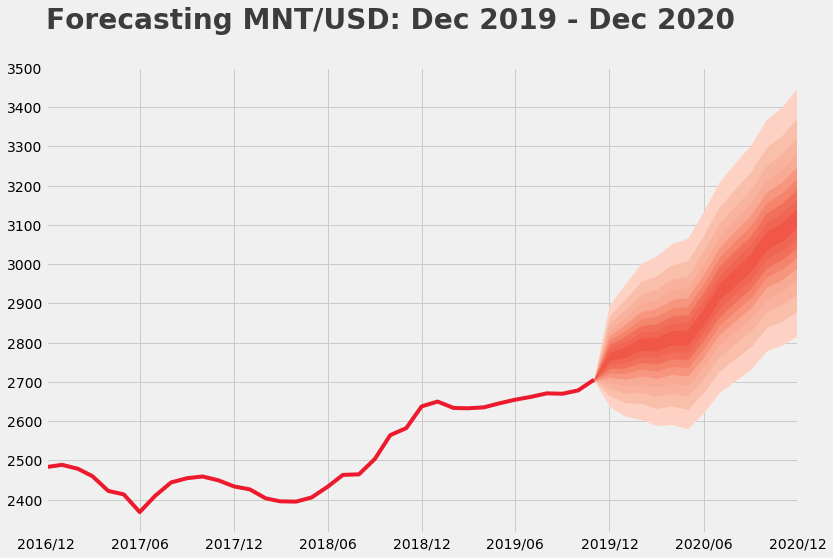

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(x_axis[:nperiod], actual, color='#ED1A2D')
ax.fill_between(x_axis[-nforecasts-1:], predicted_10['lower USD'], predicted_10['upper USD'], color='#FDD2C4')
ax.fill_between(x_axis[-nforecasts-1:], predicted_20['lower USD'], predicted_20['upper USD'], color='#F9BFAB')
ax.fill_between(x_axis[-nforecasts-1:], predicted_30['lower USD'], predicted_30['upper USD'], color='#F8B29E')
ax.fill_between(x_axis[-nforecasts-1:], predicted_40['lower USD'], predicted_40['upper USD'], color='#F9AA94')
ax.fill_between(x_axis[-nforecasts-1:], predicted_50['lower USD'], predicted_50['upper USD'], color='#F7957E')
ax.fill_between(x_axis[-nforecasts-1:], predicted_60['lower USD'], predicted_60['upper USD'], color='#F4846B')
ax.fill_between(x_axis[-nforecasts-1:], predicted_70['lower USD'], predicted_70['upper USD'], color='#F2705B')
ax.fill_between(x_axis[-nforecasts-1:], predicted_80['lower USD'], predicted_80['upper USD'], color='#F16652')
ax.fill_between(x_axis[-nforecasts-1:], predicted_90['lower USD'], predicted_90['upper USD'], color='#F15748')

# Modify axes
ax.set_xlim([x_axis[0], x_axis[-1]])
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_minor_locator(MonthLocator((3, 6, 9, 12)))
ax.xaxis.set_major_formatter(DateFormatter("%Y/%m"))
ax.xaxis.set_major_locator(MonthLocator(interval=6))
ax.yaxis.set_major_locator(FixedLocator(np.arange(2300, 3600, step=100)))

# Set title
ax.text(x=x_axis[0], y=3600, s="Forecasting MNT/USD: Dec 2019 - Dec 2020",
        fontsize=28, weight='bold', alpha=0.75);
